## The dice problem

Problem: You have a box contain a 4-sided die, a 6-sided die, an 8-sided die, a 12-sided die and a 20-sided die

After selecting a die at random, you roll it and get a 6. What is the probability that it was each of the possible dice?

Good approach to start a problem like this:
* Choose a representation for hypotheses
* Choose a representation for the data
* Write the likelihood function

In [4]:
from thinkbayes import Pmf, Suite
import matplotlib.pyplot as plt

class Dice(Suite):
    # If data large than number of sides, hypothesis is impossible so set to 0
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo

suite = Dice([4,6,8,12,20])
suite.Update(6)
suite.Print()

4 0.0
6 0.3921568627450981
8 0.29411764705882354
12 0.19607843137254904
20 0.11764705882352944


In [3]:
for roll in [6,8,7,7,5,4]:
    suite.Update(roll)
    
suite.Print()

4 0.0
6 0.0
8 0.9432484536722124
12 0.0552061280612909
20 0.001545418266496554


## The locomotive problem

Problem: You know a company numbers it's trains 1...N. You see a train with the number 60 on it. Estimate N.

We know that N >= 60

Break problem into two steps:
* What did we know about N before data? (prior)
* For any given value of N, what is likelihood of seeing data - a train with 60 (likelihood)?

We can guess prior is uniformly distrubuted between 1 and 1000 (at least one train, but not more than a 1000 and uniform probabilities across all values)



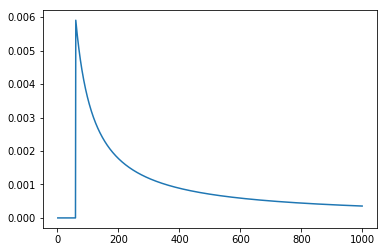

60


In [21]:
hypos = range(1,1000)

class Train(Suite):
    # Same as dice
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
        
suite = Train(hypos)
suite.Update(60)

values = []
probs = []
for val, prob in suite.Items():
    values.append(val)
    probs.append(prob)
    
plt.plot(values, probs)
plt.show()

print(values[probs.index(max(probs))])

This is the best guess for a single one of guess where we want to maximise the chance of getting the exact value. But what if we want to minimise error over a number of guesses?

We can compute the mean of the posterior distribution instead.

In [24]:
class Train(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
        
    # Similar method is already implemented, redefining here just to display code
        
    def Mean(self):
        total = 0
        for hypo, prob in self.Items():
            total += hypo * prob
        return print(total)
    
suite = Train(hypos)
suite.Update(60)
suite.Mean()

333.1836235027341


## What about the prior?

We made a lot of assumptions above, especially about the prior.

What if we look at uniform priors between 1 and 500 or 1 and 2000 instead?

In [25]:
hypos = range(1,500)
suite = Train(hypos)
suite.Update(60)
suite.Mean()

hypos = range(1,2000)
suite = Train(hypos)
suite.Update(60)
suite.Mean()

206.8038772952583
551.9730485662769


This varies the value of the posterior mean considerably!

Not a good situation, two ways to proceed:
* Get more data
* Get more background information (better prior)

With more data, posteriors based on different priors tend to converge:

In [26]:
hypos = range(1,500)
suite = Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

hypos = range(1,1000)
suite = Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

hypos = range(1,2000)
suite = Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

151.80348606277983
164.29208953758194
171.33451161537934


## Alternative prior

If we don't have access to more data, can try to collect more background information to improve prior.

Maybe assumption that a train company owning only 1 train is as likely as one owning 1000 is incorrect?

We could get information on distributions of train companies and their fleet sizes or can make some guesses on own knowledge of common distributions.

Company sizes tend to follow power laws. If there are 1000 companies with <10 trains, may be 100 companies with 100, 10 with 1000 and 1 with 10,000.

We can write this:

$PMF(x) \propto \frac{1}{x}^{\alpha}$

PMF is probability mass function of x and alpha is parameter usually close to 1

We can then construct a power law prior. This leads to smaller differences and the mean actually converges to a value around 134 with an arbitrarily large upper bound.

130.69568746044155
133.273365808993
133.9972122107673


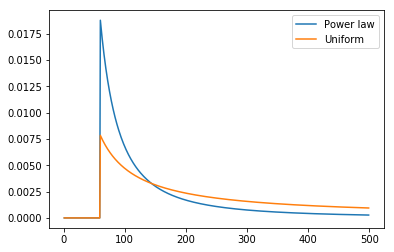

In [64]:
class Train(Suite):
    
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
        
   
    def Mean(self):
        total = 0
        for hypo, prob in self.Items():
            total += hypo * prob
        return print(total)
    
    
    def AddPlot(self, label):
        values = []
        probs = []
        for val, prob in self.Items():
            values.append(val)
            probs.append(prob)

#         print(values[probs.index(max(probs))])
        plt.plot(values, probs, label=label)


class PowerTrain(Train):
    def __init__(self, hypos, alpha=1.0):
#         super(Suite, self).__init__(hypos)
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo**(-alpha))
        self.Normalize()
     
        
hypos = range(1,500)
suite = PowerTrain(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()


hypos = range(1,1000)
suite = PowerTrain(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()


hypos = range(1,2000)
suite = PowerTrain(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()


hypos = range(1,500)
suite = PowerTrain(hypos)
suite.Update(60)
suite.AddPlot('Power law')

hypos = range(1,500)
suite = Train(hypos)
suite.Update(60)
suite.AddPlot('Uniform')

plt.legend()
plt.show()

## Credible intervals

Once a posterior distribution is calculated, it is useful to summarise with single point estimates (mean, median, or value of max likelihood) or intervals, such as a 90% **credible interval**.

One approach is to add up probabilities in the posterior and record values that correspond to 5% and 95%.

In [68]:
def Percentile(pmf, percentage):
    p = percentage / 100.0
    total = 0
    for val, prob in pmf.Items():
        total += prob
        if total >= p:
            return val
        
hypos = range(1,500)
suite = PowerTrain(hypos)
suite.Update(60)
interval = (Percentile(suite, 5), Percentile(suite, 95))
print(interval)
        
hypos = range(1,500)
suite = PowerTrain(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
interval = (Percentile(suite, 5), Percentile(suite, 95))
print(interval)

(62, 365)
(91, 235)


In [71]:
hypos = range(1,2000)
suite = PowerTrain(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
interval = (Percentile(suite, 5), Percentile(suite, 95))
print(interval)

(91, 243)


## Cumulative distribution functions

If we need to compute a higher number of percentiles it is useful to use a cumulative distribution function rather than a probability mass function

Cdfs and pmfs contain the same information about the distribution, you can always convert from one to the other. Cdf make percentile computation more efficient.

Converting from Pmf to Cdf takes time proportional to the number of values (linear time).

Cdf function stores values and probabilities in sorted list, so looking up a probability takes log time, similarly to looking up a value to get corresponding probability.

(91, 243)


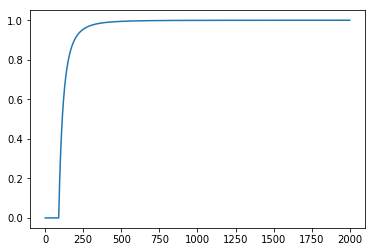

In [84]:
cdf = suite.MakeCdf()
interval = (cdf.Percentile(5), cdf.Percentile(95))
print(interval)

values = []
probs = []
for value, prob in cdf.Items():
    values.append(value)
    probs.append(prob)

plt.plot(values, probs)
plt.show()

## Choosing priors

Two main approaches: 
* Choosing a prior that best represents background information, this is an **informative prior**
* An **uninformative prior** is intended to be as unrestricted as possible. This allows data to 'speak for itself'. Sometimes unique priors can be found that represent minimal prior information about the value being computed.

Uninformative priors seem more objective. Informative priors have other advantages, and even without them Bayesian analysis is not completely objective. Subjective modelling decsisions still need to be made.

Most problems tend to have not much or a lot of data.  Prior tends to matter more when data are sparse. Using all information at your disposal can help!



In [ ]:
company_size_distribution = [10] * 1000
company_size_distribution.extend([100] * 100)
company_size_distribution.extend([1000] * 10)
company_size_distribution.extend([10000])
        
train_numbers = []
for size in company_size_distribution:
    train_numbers.extend(range(1,size+1))
    
hypos = []
for value in train_numbers:
    if value not in hypos:
        hypos.append(value)

probs = []
for hypo in hypos:
    probs.append(len([x for x in train_numbers if x == hypo]))
    
# norm_probs = [x/sum(probs) for x in probs]

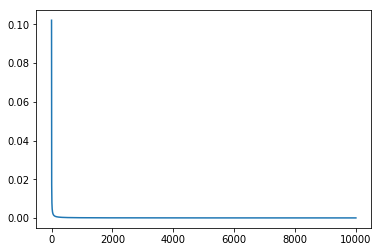

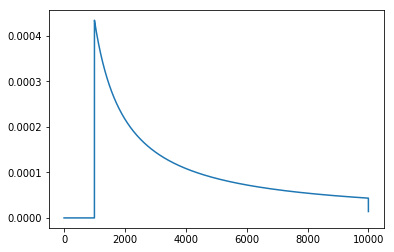

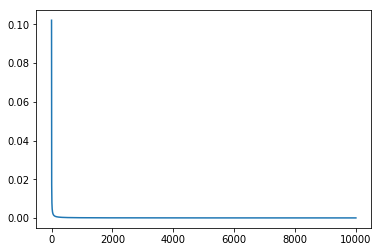

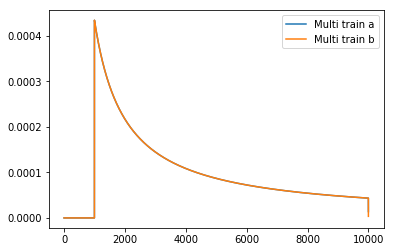

In [148]:
class Train(Suite):
    
    def Mean(self):
        total = 0
        for hypo, prob in self.Items():
            total += hypo * prob
        return print(total)
    
    
    def AddPlot(self, label):
        values = []
        probs = []
        for val, prob in self.Items():
            values.append(val)
            probs.append(prob)

#         print(values[probs.index(max(probs))])
        plt.plot(values, probs, label=label)


class MultiTrain(Train):
#     def __init__(self, hypos, probs, company_size_distribution):
#         self.company_size_distribution = company_size_distribution
# #         super(Suite, self).__init__(hypos)
#         Pmf.__init__(self)
#         for hypo, prob in zip(hypos, probs):
#             self.Set(hypo, prob)
#         self.Normalize()
        
    def __init__(self, hypos, probs, company_size_distribution):
#         super(Suite, self).__init__(hypos)
        alpha=1.0
        self.company_size_distribution = company_size_distribution
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo**(-alpha))
        self.Normalize()
     
        
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            filtered_companies_hypo = [x for x in self.company_size_distribution if x <= hypo]
            filtered_companies_data = [x for x in self.company_size_distribution if x < data]
#             number_of_companies = len(filtered_companies)
            total_number_trains = 0
            for company_size in filtered_companies_hypo:
                total_number_trains += company_size
                
            number_of_companies_with_data = len(filtered_companies_hypo) - len(filtered_companies_data)
            return number_of_companies_with_data/total_number_trains
        
## Likelihood function for adapted locomotive problem in which there are multiple companies operating.

## https://stats.stackexchange.com/questions/70096/locomotive-problem-with-various-size-companies

## https://en.wikipedia.org/wiki/Zipf%27s_law


suite = MultiTrain(hypos, probs, company_size_distribution)
suite.AddPlot('Multi train')
plt.show()
for data in [300, 280, 456, 20, 100]:
    suite.Update(data)
suite.AddPlot('Multi train a')
plt.show()

suite = MultiTrain(hypos, probs, company_size_distribution)
suite.AddPlot('Multi train')
plt.show()
for data in [300, 280, 456, 20, 100]:
    suite.Update(data)
suite.AddPlot('Multi train a')

for data in [10, 12, 23, 25, 11]:
    suite.Update(data)
suite.AddPlot('Multi train b')
plt.legend()
plt.show()
   

In [140]:
len([x for x in company_size_distribution if x <= 10])

1000